### Problem Description

We're provided with a dataset of users and movies which shows how each user has rated some of the movies from the list. Using the restricted Boltzmann machine, we want to build a machine learning model which will be able to recommend to a user a movie that they didn't watch. 

### The Approach

### Importing the Dataset

First we'll import the necessary libraries and the ratings dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ratings = pd.read_csv('./ml-1m/ratings.dat', sep = '::',
                  header = None, engine = 'python')
ratings.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
#renaming the columns for a clear interpretation
ratings.columns = ['UserID','MovieID','Rating','Timestamp']
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


We don't need the `Timestamp` column for this project, so we'll omit it. 

In [4]:
ratings = ratings.drop(columns = ['Timestamp'])
ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


The dataset is clean, and we can immediatly work with it. However, it would be nice to know what movie stands behind a certain ID. That's why we'll read in one more dataset, with the movie info.

In [5]:
#loading the movie info dataset
movies = pd.read_csv('./ml-1m/movies.dat', sep = '::',
                    header = None, engine = 'python')

movies.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
#renaming columns for a clear interpretation
movies.columns = ['MovieID', 'Name', 'Genre']
movies.head()

,MovieID,Name,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Name     3883 non-null   object
 2   Genre    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


The movies dataset is also completely clean. 

### Categorizing the Ratings

Let's now check how the ratings are distributed.

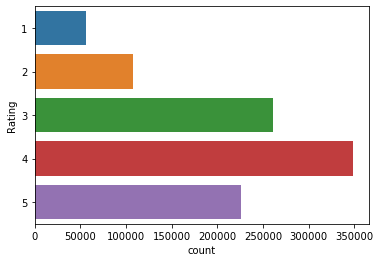

In [8]:
sns.countplot(y = 'Rating', data = ratings);

We see that 3-5 star ratings are the most common, with 4-star ratings being the predominant. 

Now we separate the ratings into binary classes `liked it` (having 5 to 3 stars), and `didn't like it` (having only 1 or 2 stars).  For the training purpose we will encode these categories as 1 and 0 respectively. In the recommendation sense, we can interpret the category `1` as the movie we would recommend and category `0` as a no-recommendation.

In [9]:
labels = pd.cut(ratings['Rating'], bins = [0,2,5], 
                        labels = [0, 1])

label_names = ["didn't like it", "liked it"]

In [10]:
ratings['Rating'] = labels
ratings = ratings.rename(columns = {'Rating' : 'Binary Rating'})
ratings.head()

,UserID,MovieID,Binary Rating
0,1,1193,1
1,1,661,1
2,1,914,1
3,1,3408,1
4,1,2355,1


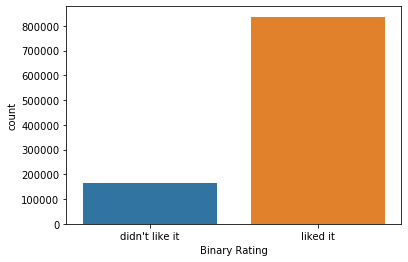

In [11]:
cplt = sns.countplot(ratings['Binary Rating'])
cplt.set(xticklabels = label_names);

We see that the good ratings are significantly predominating the bad and the mediocre ones, which means that we're dealing with the highly imbalanced dataset. 

### Data Preprocessing

Now we need to separate our dataset into a training and test set. Even though we're building an unsupervised learning model, we will use the labels in order to stratify the separation, and thus combat the dataset imbalance.

In [12]:
X = ratings
y = labels

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size = 0.25,
                                  stratify = y, random_state = 91)

X_train.shape, X_test.shape

((750156, 3), (250053, 3))

Since we are going to build the model using PyTorch, we need to convert the data into the appropriate format, which is list of lists. Each sublist of this list represents a user, and each entry of the sublist a rating for the every movie. 

In [14]:
num_of_users = max(ratings['UserID'])
num_of_movies = max(ratings['MovieID'])
print(f'A total number of {num_of_users} users have rated a total number of {num_of_movies} movies.')

A total number of 6040 users have rated a total number of 3952 movies.


In [15]:
def convert_data(data):
    
    '''Transforms the data into a list of lists.'''

    conv_data = []

    for i in range(1, num_of_users + 1):
        rat_cat = -np.ones(num_of_movies)
        movie_ids = data[data['UserID'] == i]['MovieID']
        movie_rats = data[data['UserID'] == i]['Binary Rating']

        rat_cat[movie_ids - 1] = movie_rats
        conv_data.append(rat_cat)
    
    return conv_data

In [16]:
X_train = convert_data(X_train)
X_test = convert_data(X_test)

In [17]:
#converting the list of lists into a PyTorch tensor
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [18]:
X_train.shape, X_test.shape

(torch.Size([6040, 3952]), torch.Size([6040, 3952]))

So, now we have 2D tensors (i.e. matrices) where each row corresponds to a user, and each column to a movie. The value $a_{ij}\in\{0,1\}$ of a given tensor means that the user $i$ has rated a movie $j$ and either liked it (1) or didn't like it (0). If $a_{ij} = -1$, then that means that the user $i$ did not rate the movie $j$. 

### Building and Training the RBM

Now it's time to build our restricted Boltzmann Machine. It consists of a visible and hidden layer. Each node of the visible layer corresponds to a movie, while the hidden layer has 100 nodes. We will use a mean absolute error as a way to measure loss.

In [19]:
class RBM():
    
    def __init__(self, vis_n, hidd_n):
        #initializing the weights and biases
        self.W = torch.randn(hidd_n, vis_n)
        self.a = torch.randn(1, hidd_n)
        self.b = torch.randn(1, vis_n)
        
    def sample_hidden(self, v):
        #sampling the hidden nodes from the visible values
        v = torch.mm(v, self.W.t())
        v += self.a.expand_as(v)
        p_h_v = torch.sigmoid(v)
        return p_h_v, torch.bernoulli(p_h_v)
    
    def sample_visible(self, h):
        #sampling the visible nodes from the hidden values
        h = torch.mm(h, self.W)
        h += self.b.expand_as(h)
        p_v_h = torch.sigmoid(h)
        return p_v_h, torch.bernoulli(p_v_h)
    
    def train(self, v0, vk, ph0, phk):
        #readjusting the weights after the Gibb's sampling
        self.W += torch.mm(ph0.t(), v0) - torch.mm(phk.t(), vk)
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)

In [20]:
#forming the restricted boltzmann machine
vis_n = num_of_movies
hidd_n = 100
epochs = 10
batch_size = 100

rbm = RBM(vis_n, hidd_n)

We now train the RBM. The training set represents just a portion of the total ratings each user has given to all the movies they have rated. By trying to reconstruct this portion of the data, the RBM will perform an unsupervised learning.

In [21]:
#training the rbm
for epoch in range(epochs):
    
    train_loss = 0
    steps = 0
    
    for user in range(0, num_of_users - batch_size, batch_size):
        
        #initializing the visible nodes
        v0 = X_train[user : user + batch_size]
        vk = v0.clone()
        
        #performing a 10-step Gibbs sampling
        for k in range(10):
            _, hk = rbm.sample_hidden(vk)
            _, vk = rbm.sample_visible(hk)
            vk[v0 < 0] = -1
        
        #getting the probabilities for the hidden nodes
        ph0, _ = rbm.sample_hidden(v0)
        phk, _ = rbm.sample_hidden(vk)
        
        #performing a training step
        rbm.train(v0, vk, ph0, phk)
    
        #calculating the loss for the step
        train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
        steps += 1
        
    print(f'epoch: {epoch + 1}, loss: {train_loss/steps}')

epoch: 1, loss: 0.2442883998155594
epoch: 2, loss: 0.2283667027950287
epoch: 3, loss: 0.22792452573776245
epoch: 4, loss: 0.22753039002418518
epoch: 5, loss: 0.2278277724981308
epoch: 6, loss: 0.2271387130022049
epoch: 7, loss: 0.22783921658992767
epoch: 8, loss: 0.22776159644126892
epoch: 9, loss: 0.22769232094287872
epoch: 10, loss: 0.22779178619384766


The training of the RBM didn't take long, and the loss of 0.2277 means that we have 77.23% accuracy on the training set.

### Evaluating the RBM

Let's now see how the RBM behavies on the test set. The test set represents the portion of users' ratings not included in the training set. We will now try to reconstruct these ratings using our RBM. 

In [22]:
test_loss = 0
steps = 0

for user in range(num_of_users):
    
    target_vec = X_test[user : user + 1].data
    
    #checking if there is any rating in a test set for a given user
    if(len(target_vec[target_vec >= 0] > 0)):
        v = target_vec.clone()
        #performing a 1-step Gibbs sampling to obtain a reconstruction
        _, v = rbm.sample_hidden(v)
        _, v = rbm.sample_visible(v)
        test_loss += torch.mean(torch.abs(target_vec[target_vec>=0]-v[target_vec>=0]))
        steps += 1

test_loss = float(test_loss/steps)
print(f'test loss: {round(test_loss, 4)}')

test loss: 0.2097


The average loss of 0.2097 means that we have achieved accuracy of 79.03% on the test set. Our RBM has almost the same loss for both the training and the test set, and this means that our model is robust. 

In the next step we will merge the ratings data for all the users and all the (rated) movies, and try to reconstruct the whole recommendation data just from the training portion. 

In [23]:
#reconstructing the whole like/dislike data
reconst_loss = 0
steps = 0

for user in range(num_of_users):
    
    input_vec = X_train[user : user + 1].data
    target_vec = (X_train[user:user+1] + X_test[user:user+1]).data + 1
    
    #checking if there is any rating in a test set for a given user
    if(len(target_vec[target_vec >= 0]) > 0):
        #performing a 1-step Gibbs sampling to obtain a reconstruction
        _, output_vec = rbm.sample_hidden(input_vec)
        _, output_vec = rbm.sample_visible(output_vec)
        reconst_loss += torch.mean(torch.abs(target_vec[target_vec>=0] - output_vec[target_vec>=0]))
        steps += 1

reconst_loss = float(reconst_loss/steps)
print(f'reconstruction loss: {round(reconst_loss, 4)}')

reconstruction loss: 0.2078


In case when we try to reconstruct the whole data, we have an accuracy of 79.22%. 

Let's see how many like/dislike ratings our model misses while trying to reconstruct the ratings for some random user. 

In [45]:
def reconst_example():
    
    '''Computes the number and the 
    percentage of misses for a random user'''
    
    user = np.random.randint(len(X_train))
    
    input_vec = X_train[user : user + 1].data
    target_vec = (X_train[user:user+1] + X_test[user:user+1]).data + 1
    _, output_vec = rbm.sample_hidden(input_vec)
    _, output_vec = rbm.sample_visible(output_vec)
    
    
    a = torch.sum(target_vec[target_vec >= 0])
    b = torch.sum(torch.round(output_vec[target_vec >= 0]))
    missrate = int(abs(a-b))
    missrate_purc = missrate/len(target_vec[target_vec >= 0])
    missrate_purc = round(missrate_purc*100, 2)
    
    print(f'Missratings for user no.{user}: {missrate}, {missrate_purc}%')

In [25]:
for _ in range(10):
    reconst_example()

Missratings for user no.844: 2, 3.85%
Missratings for user no.219: 8, 7.84%
Missratings for user no.3698: 7, 11.48%
Missratings for user no.1365: 4, 2.8%
Missratings for user no.5095: 21, 7.84%
Missratings for user no.2537: 4, 16.0%
Missratings for user no.2710: 14, 36.84%
Missratings for user no.2699: 34, 11.56%
Missratings for user no.408: 18, 6.06%
Missratings for user no.3733: 9, 18.0%


### Making the Recommendations

Let's pick a random user and see wheather we would recommend them some movie they haven't watched yet. 

In [28]:
from tabulate import tabulate

X_whole = X_train + X_test + 1
recom = ["Not Recommended", "Recommended"]

def recommendation():
    
    k = np.random.randint(len(X_whole))
    print(f'The user {k} liked the movies:\n')
    liked = np.random.choice(np.where(X_whole[k] == 1)[0], 5,
                            replace = False)
    like_tab = []
    for movie in liked:
        l = movies.loc[movie, ['Name', 'Genre']].tolist()
        like_tab.append([l[0],l[1]])
    print(tabulate(like_tab))
    print('..................\n')
    
    
    print("but didn't like the movies:\n")
    disl = np.where(X_whole[k] == 0)[0]
    disliked = np.random.choice(disl, min(5, len(disl)),
                            replace = False)
    disl_tab = []
    for movie in disliked:
        l = movies.loc[movie, ['Name', 'Genre']].tolist()
        disl_tab.append([l[0],l[1]])
    print(tabulate(disl_tab))
    print('..................\n')
    
    
    print("Recommendations:\n")
    unrated = np.random.choice(np.where(X_whole[k] == -1)[0], 5,
                            replace = False)
    _, ratings_pred = rbm.sample_hidden(X_whole[k : k+1])
    _, ratings_pred = rbm.sample_visible(ratings_pred)
    ratings_pred = ratings_pred[0][unrated]
    ratings_pred = torch.round(ratings_pred)
    ratings_pred = np.array(ratings_pred, dtype = 'int8')
    rec_tab = []
    for movie, rat in zip(unrated, ratings_pred):
        l = movies.loc[movie, ['Name', 'Genre']].tolist()
        rec_tab.append([l[0], l[1], recom[rat]])
    print(tabulate(rec_tab))

In [44]:
recommendation()

The user 16 liked the movies:

----------------------------------------------  -----------------------
Hamlet (1964)                                   Drama
Sneakers (1992)                                 Crime|Drama|Sci-Fi
Mommie Dearest (1981)                           Drama
Star Trek IV: The Voyage Home (1986)            Action|Adventure|Sci-Fi
400 Blows, The (Les Quatre cents coups) (1959)  Drama
----------------------------------------------  -----------------------
..................

but didn't like the movies:

-------------------------------------  --------------------------
Angel Heart (1987)                     Film-Noir|Mystery|Thriller
In & Out (1997)                        Comedy
Open Your Eyes (Abre los ojos) (1997)  Drama|Romance|Sci-Fi
Brighton Beach Memoirs (1986)          Comedy
Ratchet (1996)                         Drama|Thriller
-------------------------------------  --------------------------
..................

Recommendations:

---------------------------------

### Conclusions

Using the restricted Boltzmann machine we were able to build a robust binary movie recommendation system based on previosly rated movies. In addition to being robust, our model has very simple architecture and is trained very fast. 